# A/B–тестирование акционных предложений

### 1.1 Условие

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

### 1.2 Исходные данные
В качестве входных данных имеется файл ab_test.csv с информацией:
- user_id - пользователь
- revenue - затраты за время проведения АВ теста
- testgroup - группа

In [1]:
import pandas as pd
import seaborn as sns
import scipy
import pylab
from scipy import stats
from scipy.stats import levene, shapiro, chi2_contingency, ttest_ind

import matplotlib.pyplot as plt

In [2]:
abdf = pd.read_csv(r'C:\Users\pletn\Documents\notebooks\final_projects\1\ab_test.csv', sep=';')

### 1.3 Разведочный анализ

In [3]:
abdf.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [4]:
abdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [5]:
abdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [6]:
# Имеются ли дубликаты по user_id

abdf.shape[0] != abdf.user_id.nunique()

False

In [7]:
# Количество всех пользователей, платящих пользователей и конверсия в каждой группе 

cr_table = abdf.groupby('testgroup').agg({'user_id' : 'count'}).rename(columns = {'user_id' : 'all_users'})\
    .merge(\
           abdf.query('revenue > 0').groupby('testgroup').agg({'user_id' : 'count'})\
           .rename(columns = {'user_id' : 'paiment_users'}), 
           how = 'left', 
           on = 'testgroup')\
    .reset_index()
cr_table['cr'] = cr_table.paiment_users / cr_table.all_users
cr_table

,testgroup,all_users,paiment_users,cr
0,a,202103,1928,0.009540
1,b,202667,1805,0.008906


In [8]:
# Посчитаем показатели ARPPU и ARPU в каждой группе

revenue_table = abdf.groupby('testgroup').agg({'revenue' : 'sum'})\
    .merge(cr_table, how = 'left', on = 'testgroup')
revenue_table['ARPU'] = revenue_table.revenue / revenue_table.all_users
revenue_table['ARPPU'] = revenue_table.revenue / revenue_table.paiment_users 
revenue_table

,testgroup,revenue,all_users,paiment_users,cr,ARPU,ARPPU
0,a,5136189,202103,1928,0.009540,25.413720,2663.998444
1,b,5421603,202667,1805,0.008906,26.751287,3003.658172


In [9]:
# Относитальное изменение метрик в группах:

b_to_a_metrics = revenue_table.drop(labels = ['testgroup'], axis=1)

b_to_a_metrics.loc['% b to a'] = round((b_to_a_metrics.iloc[1] / b_to_a_metrics.iloc[0] - 1) * 100, 2)
b_to_a_metrics

,revenue,all_users,paiment_users,cr,ARPU,ARPPU
0,5136189.00,202103.00,1928.00,0.009540,25.413720,2663.998444
1,5421603.00,202667.00,1805.00,0.008906,26.751287,3003.658172
% b to a,5.56,0.28,-6.38,-6.640000,5.260000,12.750000


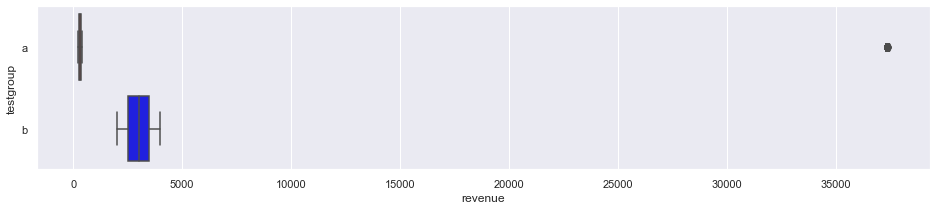

In [29]:
# Посмотрим на распределения ARPPU для контрольной и тестовой группы

sns.set(rc={'figure.figsize':(16,3)})
colors = ['red', 'blue']
sns.set_palette(colors)
sns.boxplot(data = abdf, x = abdf.query('revenue > 0').revenue, y = abdf['testgroup'], orient = 'h',
           order=["a", "b"]);

In [11]:
# Мы видим, что в группе А имеются пользователи, которые на порядок потратили больше, чем все остальные в группах А и В.
# Посчитаем количество таких пользователей. Далее будем называть ТОП пользователи. 

abdf.query('revenue > 35000').shape[0]

123

In [12]:
# Процент ТОП пользователей в группе А.

str(round (123 / 1928 * 100, 2)) + '%'

'6.38%'

In [13]:
"Процент потречанных денег ТОП пользователей по отношению ко всей группе А = " +\
str(round(abdf.query('revenue > 35000')['revenue'].sum()\
          / abdf.query('testgroup == "a"')['revenue'].sum() 
          * 100, 2))\
+ '%'

'Процент потречанных денег ТОП пользователей по отношению ко всей группе А = 89.37%'

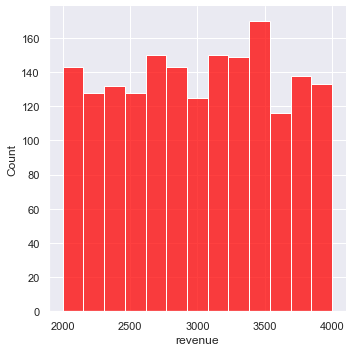

In [14]:
# 123 пользователя или 6,38% от всей группы А потратили 89,37% всех трат всей группы А. Исключать ТОП пользователей не будем.
# Сравним с распределением трат пользователей в группе В.

sns.displot(abdf.query('revenue > 0 & testgroup == "b"')['revenue']);

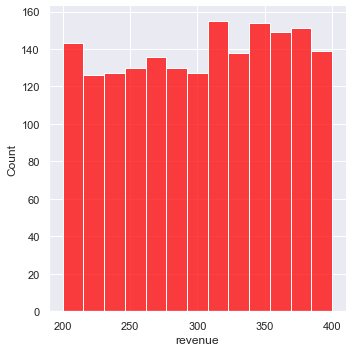

In [15]:
# Так же посмотрим на распределение трат пользователей в группе А без учета ТОП пользователей

sns.displot(abdf.query('revenue < 35000 & testgroup == "a" & revenue > 0')['revenue']);

In [16]:
# Создадим массивы данных для дальнейшего анализа

ARPU_a = abdf.query('testgroup == "a"')['revenue']
ARPU_b = abdf.query('testgroup == "b"')['revenue']
ARPPU_a = abdf.query('revenue > 0 & testgroup == "a"')['revenue']
ARPPU_b = abdf.query('revenue > 0 & testgroup == "b"')['revenue']
cr_table_chi2 = cr_table[['all_users', 'paiment_users']]

### 1.3.1 Результаты разведочного анализа: 

- Группа А содержит 202103 пользователя, из которых 1928 платящих, конверсия 0.954%. Группа А содержит 202667 пользователя, из которых 1805 платящих, конверсия 0.891%. В тестовой группе конверсия снизилась на 6.64%.
- ARPPU увеличился с 2664 (А) до 3004 (В) или на 12.75%. 
- ARPU увеличился с 25.41 (А) до 26.75 (В) или на 5.26%. 
- В группе А присутствует группа ТОП пользоветелей (123 пользователя или 6.38% от общего числа группы А), которые принесли 89,37% дохода от всей группы А. Считать их выбросами и исключать из анализа не будем.
- Поведение пользователей в группе А, без учета ТОП пользователей, похоже на поведение пользователей в группе В - распределение затрат платящих пользователей равномерное в диапазоне от 200 до 400 для пользователей в группе А и от 2000 до 4000 для пользователей в группе В. 

### 1.4 Выбор и расчет метрик.

По имеющимся данным мы можем определить:
- ARPU - средний доход принесенный пользователем 
- ARPPU - средний доход с платящего пользователя 
- CR -конверсию в покупку

### 1.5 Формирование гипитез и выбор уровня значимости

# ARPU = CR * ARPPU

Для начала проверим гипотезу самой верхнеуровневой метрики, которую можем достать из имеющихся данных:
1. Н0: ARPU_A = ARPU_B, H1: ARPU_A < ARPU_B. 

В случае невозможноси отклонить Н0 далее декомпозируем метрику на две компоненты ARPPU и CR и проверим следующие гипотезы:

2. Н0: ARPPU_A = ARPPU_B. H1: ARPPU_A < ARPPU_B.
3. Н0: CR_A = CR_B. H1: CR_A > CR_B.

Уровень значимости α = 0.05

### 1.6 Выбор статистических тестов
1. ARPU - среднее, оценим возможность применения t-test. 
2. ARPPU - среднее, оценим возможность применения t-test. 
3. CR - категориальная переменная, будем использовать критерий хи-квадрат.

Для оценки возможности применения t-test убедимся:
1. В гомогенности дисперсий с помощью критерия Левена α = 0.05.
2. Нормальность будем проверять с помощью теста Шапиро-Уилка α = 0.05.

In [40]:
# Проверим гомогенность дисперсий для ARPU

levene(ARPU_a, ARPU_b)

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

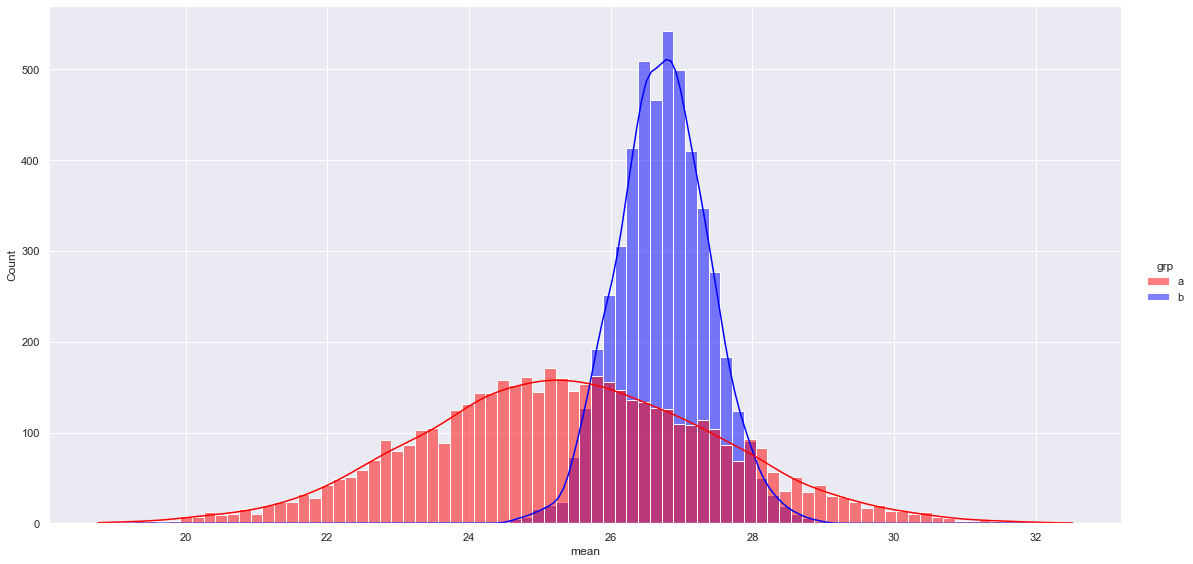

In [59]:
# Проверим нормальность распределения средних в группах А и В

ARPU_mean_a = []
ARPU_mean_b = []

for i in range(5000):
    ARPU_mean_a.append(ARPU_a.sample(len(ARPU_a), replace = True).mean())
    ARPU_mean_b.append(ARPU_b.sample(len(ARPU_b), replace = True).mean())

a = pd.DataFrame(data = ARPU_mean_a, columns = ['mean'])
b = pd.DataFrame(data = ARPU_mean_b, columns = ['mean'])
a['grp'] = 'a'
b['grp'] = 'b'
AB_means = pd.concat([a, b]).reset_index()

sns.displot(AB_means, x='mean', hue='grp', height=8, aspect=2, kde = True);

In [60]:
shapiro(ARPU_mean_a)

ShapiroResult(statistic=0.9996057152748108, pvalue=0.4311487078666687)

In [61]:
shapiro(ARPU_mean_b)

ShapiroResult(statistic=0.9993993639945984, pvalue=0.10065769404172897)

Среднее ARPU в группах А и В распределены нормально и имеют гомогенные дисперсии, в связи с этим для проверки 1ой гипотезы будем использовать t-test.

### 1.7 Статистическая проверка гипотез

### 1.7.1 Проверка гипотезы Н0: ARPU_A = ARPU_B. H1: ARPU(A) < ARPU(B).

In [62]:
ttest_ind(ARPU_a, ARPU_b)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

*Вывод:* p-value > α остаемся при Н0: ARPU_A = ARPU_B. Необходимо проверить гипотезы 2 и 3.

### 1.7.2 Проверка гипотезы Н0: ARPPU_A = ARPPU_B. H1: ARPPU(A) < ARPPU(B).

In [22]:
# Проверим гомогенность дисперсий для ARPU

levene(ARPPU_a, ARPPU_b)

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

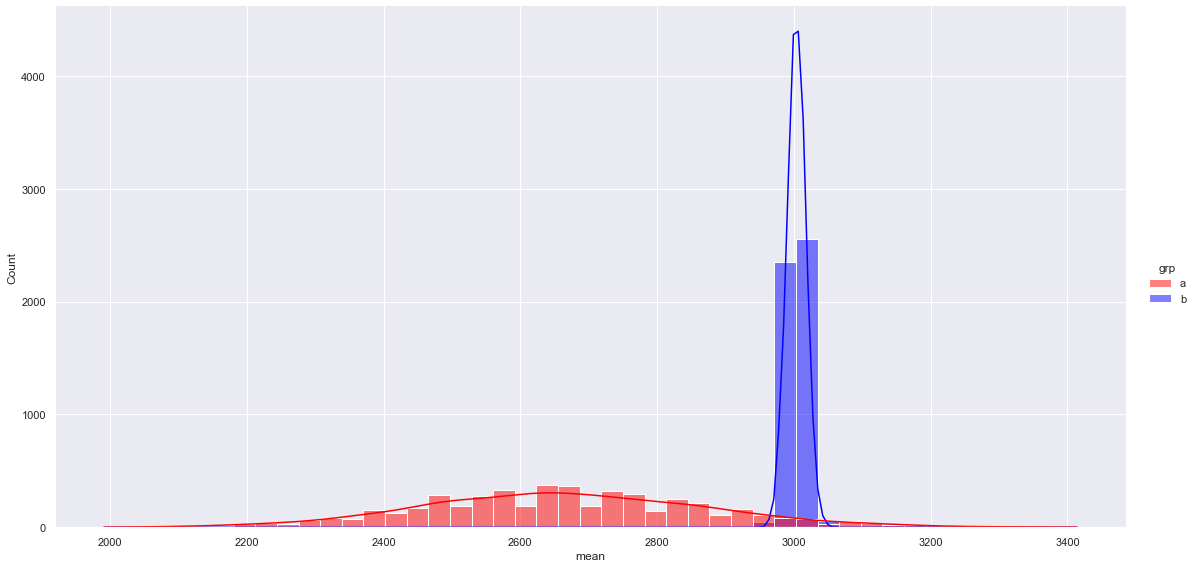

In [23]:
# Проверим нормальность распределения средних в группах А и В

ARPPU_mean_a = []
ARPPU_mean_b = []

for i in range(5000):
    ARPPU_mean_a.append(ARPPU_a.sample(len(ARPPU_a), replace = True).mean())
    ARPPU_mean_b.append(ARPPU_b.sample(len(ARPPU_b), replace = True).mean())
    
a = pd.DataFrame(data = ARPPU_mean_a, columns = ['mean'])
b = pd.DataFrame(data = ARPPU_mean_b, columns = ['mean'])
a['grp'] = 'a'
b['grp'] = 'b'
AB_means = pd.concat([a, b]).reset_index()

sns.displot(AB_means, x='mean', hue='grp', height=8, aspect=2, kde = True);

In [45]:
shapiro(ARPPU_mean_a)

ShapiroResult(statistic=0.9985747933387756, pvalue=0.00019627985602710396)

In [46]:
shapiro(ARPPU_mean_b)

ShapiroResult(statistic=0.9997641444206238, pvalue=0.879988431930542)

Группы имеют отличную дисперсию и среднее в группе А распределено не нормально , это так же видно и визуально, присутствуют сильные "провалы" на графике распредления из-за наличия пользователей, которые потратили существенно больше остальных. Таких пользователей "выбросами" считать нельзя, поэтому не будем их удалять из выборки. При этом распредление средних ARPPU в группе В нормальное. Тем не менее, в связи с тем, что не удволетворяется критерии для применения t-test, для проверки гипотезы о равенстве ARPPU будем использовать bootstrap.

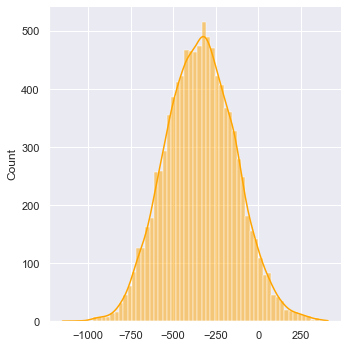

In [104]:
ARPPU_mean_delta = []

for i in range(10000):
    ARPPU_mean_delta.append(ARPPU_a.sample(len(ARPPU_a), replace = True).mean() - \
                            ARPPU_b.sample(len(ARPPU_b), replace = True).mean())

sns.displot(ARPPU_mean_delta, color = 'orange', kde = True);

In [105]:
pd.DataFrame(ARPPU_mean_delta).quantile(0.95)

0   -0.943065
Name: 0.95, dtype: float64

*Вывод:* Так как 0 не попадает в границы доверительного интервала ($-\infty$; - 0,94] принимаем H1: ARPPU(A) < ARPPU(B).

### 1.7.3. Проверка гипотезы Н0: CR_A = CR_B. H1: CR_A > CR_B.

In [106]:
chi2_contingency(cr_table_chi2)

(4.294148751290091,
 0.03824373651044168,
 1,
 array([[202166.51498275,   1864.48501725],
        [202603.48501725,   1868.51498275]]))

*Вывод:* p-value < α. Принимаем H1: CR_A > CR_B.

### 1.7.4. Итоговый результат проверки гипотез:
1. Н0: ARPU_A = ARPU_B
2. H1: ARPPU_A < ARPPU_B
3. H1: CR_A > CR_B


### 1.8. Выводы:

Проведен статистический анализ данных A/B теста акционного предложения.

**Сформулированы три гипотезы:**
1. Н0: ARPU_A = ARPU_B. H1: ARPU_A < ARPU_B.
2. Н0: ARPPU_A = ARPPU_B. H1: ARPPU_A < ARPPU_B.
3. Н0: CR_A = CR_B. H1: CR_A > CR_B.

**Проверка гипотез осуществлялась для уровня значимости:**
- α = 0.05

**Выбраны тесты для проверки гипотез:**
1. Для ARPU выбран t-test. 
2. Для ARPPU выбран bootstrap. 
3. Для CR выбран критерий хи-квадрат.

**Результаты проверки гипотез:**
1. p-value > α. Остаемся при Н0: ARPU_A = ARPU_B.
2. p-value < α. Принимается H1: ARPPU_A < ARPPU_B.
3. p-value < α. Принимается H1: CR_A > CR_B. 

**Итоговый вывод:**
По результатам A/B теста новое акционное предложение увеличило ARPPU и одновременно уменьшило конверсию CR, верхнеуровневая метрика ARPU не изменилась. При равных ARPU лучше выбрать новое акционное предложение (группа В), т.к. кардинально изменилось поведение пользователей. Если в группе А 89,37% дохода принесли ТОП пользователей 6.38%, то в группе В распределение трат платящих пользователей равномерное в диапазоне от 2000 до 4000 рублей. Данная бизнес-модель более диверсифицирована и дает больше возможностей для дальнейшего развития бизнеса.